In [1]:
import functools
import numpy as np
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


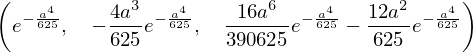

In [2]:
a = sympy.symbols('a')
iF = sympy.exp(-(a/5)**4)
F = iF.diff(a)
dF = F.diff(a)
lambda_iF = sympy.lambdify((a,), iF)
lambda_F = sympy.lambdify((a,), F)
lambda_dF = sympy.lambdify((a,), dF)
iF, F, dF

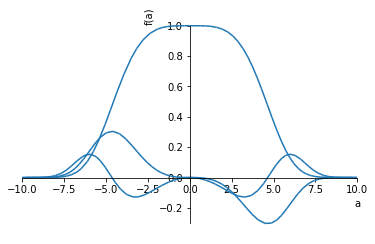

In [3]:
sympy.plot(iF, F, dF)
plt.show()

In [4]:
xtrain = (np.random.random((100000,2)) - 0.5) * 20
xtest = (np.random.random((10000,2)) - 0.5) * 20
ytrain, ytest = lambda_F(xtrain), lambda_F(xtest)

In [5]:
def build_nn_pair():
    X = X_input = keras.layers.Input((2,))
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(128, activation='tanh')(X)
    for _ in range(3):
        X_skip = X
        X = keras.layers.Dense(128, activation='relu')(X)
        X = keras.layers.Dense(128)(X)
        X = keras.layers.Add()([X, X_skip])
        X = keras.layers.Activation('tanh')(X)
    X = keras.layers.Dense(2)(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_jacobian(x):
        return K.reshape(K.stack([
            K.gradients(x[1][:,ix], x[0])[0]
            for ix in range(2)
        ], axis=1), (-1,2,2))
    def compute_grad(x):
        j = compute_jacobian(x)
        return K.reshape(K.stack([
            j[:,ix,ix]
            for ix in range(2)
        ], axis=1), (-1,2))
    X = keras.layers.Lambda(
        lambda x: compute_grad(x) + K.sum(x[1])*0,
        output_shape=(2,))([X_input, X])
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile('nadam', 'mse', ['mae'])
    return M_Integral, M_DIntegral

In [6]:
M_Integral, M_DIntegral = build_nn_pair()
M_IDerivative, M_Derivative = build_nn_pair()
X = X_input = keras.layers.Input((2,))
X_DI = M_DIntegral(X_input)
X_ID = M_IDerivative(X_input)
X_add = keras.layers.Lambda(lambda x: sum(x) / 2)([X_DI, X_ID])
X_sub = keras.layers.Lambda(lambda x: (x[1] - x[0]) / 2)([X_DI, X_ID])
X_sub = keras.layers.ActivityRegularization(l2=0.01)(X_sub)
X = keras.layers.Add()([X_add, X_sub])
M = keras.Model(X_input, X)
M.compile('nadam', 'mse', ['mae'])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            99722       input_3[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 2)            99722       input_3[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           model_2[1][0]                    
                                                                 model_3[2][0]                    
__________

In [7]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=10, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
    keras.callbacks.EarlyStopping(patience=10),
])

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 6s 60us/step - loss: 0.0211 - mean_absolute_error: 0.0815 - val_loss: 0.0166 - val_mean_absolute_error: 0.0438
Epoch 2/10
100000/100000 [==============================] - 4s 45us/step - loss: 0.0084 - mean_absolute_error: 0.0567 - val_loss: 0.0173 - val_mean_absolute_error: 0.0410
Epoch 3/10
100000/100000 [==============================] - 4s 45us/step - loss: 0.0070 - mean_absolute_error: 0.0513 - val_loss: 0.0117 - val_mean_absolute_error: 0.0361
Epoch 4/10
100000/100000 [==============================] - 5s 45us/step - loss: 0.0062 - mean_absolute_error: 0.0482 - val_loss: 0.0088 - val_mean_absolute_error: 0.0379
Epoch 5/10
100000/100000 [==============================] - 4s 45us/step - loss: 0.0059 - mean_absolute_error: 0.0473 - val_loss: 0.0055 - val_mean_absolute_error: 0.0314
Epoch 6/10
100000/100000 [==============================] - 4s 45us/step - loss: 0.0056 - mean

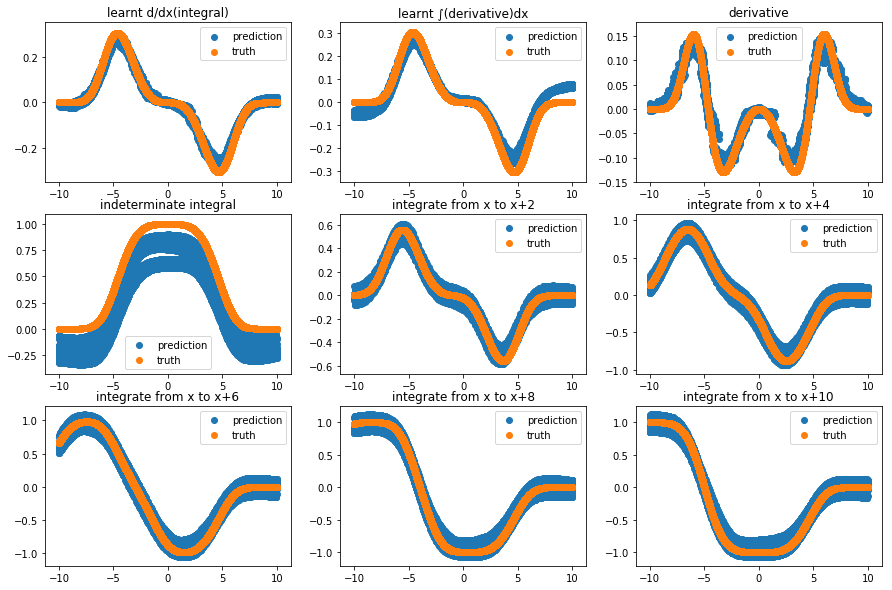

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest, M_DIntegral.predict(xtest), label='prediction')
plt.scatter(xtest, ytest, label='truth')
plt.legend()
plt.subplot(3,3,2)
plt.title('learnt ∫(derivative)dx')
plt.scatter(xtest, M_IDerivative.predict(xtest), label='prediction')
plt.scatter(xtest, ytest, label='truth')
plt.legend()
plt.subplot(3,3,3)
plt.title('derivative')
plt.scatter(xtest, M_Derivative.predict(xtest), label='prediction')
plt.scatter(xtest, lambda_dF(xtest), label='truth')
plt.legend()
plt.subplot(3,3,4)
plt.title('indeterminate integral')
plt.scatter(xtest, M_Integral.predict(xtest), label='prediction')
plt.scatter(xtest, lambda_iF(xtest), label='truth')
plt.legend()
for i in range(5):
    D = (i+1)*2
    plt.subplot(3,3,i+5)
    plt.title(f'integrate from x to x+{D}')
    plt.scatter(xtest, M_Integral.predict(xtest + D) - M_Integral.predict(xtest), label='prediction')
    plt.scatter(xtest, lambda_iF(xtest + D) - lambda_iF(xtest), label='truth')
    plt.legend()
plt.show()